# Introduction: ChromBPNet optimization, validation, and downstream processing 

The purpose of this notebook is to train a ChromBPNet model we can use to interpret 4 timepoints of Drosophila development. To do this we will:

1. Train a Tn5 bias model.
2. Validate that the bias model is indeed learning only Tn5 bias. 
3. Once (1-2) is validated, optimize a ChromBPNet architecture for our "busiest" timepoint (see description below for more details).
4. Once the best model architecture is selected, we will do a multi-fold training step to ensure that our training, validation, and test datasets are well established and stable. This will require running contribution and TF-MoDISco. We will do this for a single timepoint.



5. Compare performance metrics

# Computational Setup

In [1]:
# Configurations
import warnings;warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation; deprecation._PRINT_DEPRECATION_WARNINGS = False

#Modules
import os
import re
import json
import sys
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import plotnine
from plotnine import *
import pickle
from glob import glob
from itertools import product, compress
from keras import backend as K
from scipy.stats import pearsonr, spearmanr, multinomial, describe
import tensorflow as tf
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from datetime import datetime

#Setup
os.chdir('/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/analysis/')
np.random.seed(10)
%matplotlib inline

#Custom functions
sys.path.insert(0, f'scripts/py')
from chrombpnet_metrics_suppl import compute_auprc, collect_counts
from motif_functions import import_modisco_seqlets_txt, map_modisco_coordinates_to_genome

sys.path.insert(0, f'/home/mw2098/bin/chrombpnet-lite/src/')
from metrics import softmax
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data

#Variables
figure_filepath = f'figures/3_acc_chrombpnet_training'
TIMEPOINTS=['1to15','15to2','2to25','25to3']
BASE_DIR=os.getcwd()
REFERENCE_PREFIX='dm6'
INPUT_SEQLEN=2114
OUTPUT_SEQLEN=1000

#Dependent variables
os.chdir(BASE_DIR)
MODEL_DIR=BASE_DIR + '/models'

CHROM_SIZES='../data/indexes/dm6.chrom.sizes.txt'
ALL_CHROMS = pd.read_csv('../data/indexes/dm6.chroms.txt', sep = '\t', header = None, names = ['chr']).chr.tolist()
REFERENCE_GENOME='../data/indexes/bowtie2/dm6.fa'


In [2]:
!mkdir -p {figure_filepath}
!mkdir -p chrombpnet/

## Helper functions

Function to write a bias training -> contribution generation script in SGE.

In [3]:
def write_train_bias_sge(OUTPUT_SGE_PATH,
                         BASE_DIR, REFERENCE_PREFIX, INPUT_SEQLEN, OUTPUT_SEQLEN, 
                         CHROM_SIZES, REFERENCE_GENOME,
                         CVG, PEAK_BED, NONPEAK_BED,
                         TEST_CHROM, VALID_CHROM, THRESH, SAMPLE_MODEL):
    
    sge_header = ['#$ -cwd', '#$ -S /bin/bash', '#$ -N train_chrombpnet_bias_model', '#$ -pe smp 80', 
                  '#$ -l h_vmem=2G', '#$ -l h_rt=24:00:00', '#$ -V', '#$ -p -20']
    ld_path = ['LD_LIBRARY_PATH=/usr/lib64:/usr/local/cuda-11.5/lib64:/usr/local/cuda-11.5/extras/CUPTI/lib64:/lib/nccl/cuda-11.5:/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/extras/CUPTI/lib64:/lib/nccl/cuda-11.0:/n/apps/CentOS7/install/rbenv-0.3.0/rbenv/libexec:/n/apps/CentOS7/lib64::/n/apps/CentOS7/install/guppy-2.3.1/lib:/n/apps/CentOS7/lib:/n/apps/CentOS7/proteomics/lib']
    input_data = [f'BASE_DIR={BASE_DIR}', f'REFERENCE_PREFIX={REFERENCE_PREFIX}', f'INPUT_SEQLEN={INPUT_SEQLEN}',
                  f'OUTPUT_SEQLEN={OUTPUT_SEQLEN}', f'CVG={CVG}', f'PEAK_BED={PEAK_BED}', f'NONPEAK_BED={NONPEAK_BED}',
                  f'TEST_CHROM={TEST_CHROM}', f'VALID_CHROM={VALID_CHROM}', 
                  f'CHROM_SIZES={CHROM_SIZES}', f'REFERENCE_GENOME={REFERENCE_GENOME}',
                  f'THRESH={THRESH}', f'SAMPLE_MODEL={SAMPLE_MODEL}']
    
    dep_params = ['conda activate /home/mw2098/anaconda3/envs/chrombpnet', 'cd $BASE_DIR', 
                  'MODEL_DIR=$BASE_DIR/chrombpnet/models', 'mkdir -p $MODEL_DIR', 
                  'METRICS_DIR=$BASE_DIR/chrombpnet/metrics', 'mkdir -p $METRICS_DIR',
                  'INTERPRET_DIR=$BASE_DIR/chrombpnet/shap', 'mkdir -p $INTERPRET_DIR']
    
    bias_model_train = [
                   '/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/train_bias.py \\',
                   '    --genome $REFERENCE_GENOME --test-chr $TEST_CHROM --val-chr $VALID_CHROM --batch-size 32 \\', 
                   '    --bigwig $CVG --peaks $PEAK_BED --nonpeaks $NONPEAK_BED --threshold-factor $THRESH \\',
                   f'    --inputlen $INPUT_SEQLEN --outputlen $OUTPUT_SEQLEN \\',
                   f'    --output-prefix $MODEL_DIR/bias_model_thresh_$THRESH']
    
    #This will involve having a dummy model to evaluate by. We will ignore combined model features and only focus on performance metrics of bias model.
    bias_model_metrics = [
               '/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/metrics.py \\',
               '    --genome $REFERENCE_GENOME --test-chr $TEST_CHROM --batch-size 32 \\', 
               '    --bigwig $CVG --peaks $PEAK_BED --nonpeaks $NONPEAK_BED \\',
               f'   --output-prefix $METRICS_DIR/bias_metrics_thresh_$THRESH \\',
               f'   --bias-model $MODEL_DIR/bias_model_thresh_$THRESH.h5 --chrombpnet-model $SAMPLE_MODEL']
    
    bias_shap_counts = [
                        '/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/interpret.py \\',
                        '    --genome $REFERENCE_GENOME --regions $NONPEAK_BED --model $MODEL_DIR/bias_model_thresh_$THRESH.h5 \\',
                        '    --output-prefix $INTERPRET_DIR/shap_thresh_$THRESH --profile-or-counts counts']
    bias_shap_profile = ['/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/interpret.py \\',
                        '    --genome $REFERENCE_GENOME --regions $NONPEAK_BED --model $MODEL_DIR/bias_model_thresh_$THRESH.h5 \\',
                        '    --output-prefix $INTERPRET_DIR/shap_thresh_$THRESH --profile-or-counts profile']      
    
    cmds = sge_header + ld_path + input_data + dep_params + bias_model_train + bias_shap_counts + bias_shap_profile
    with open(OUTPUT_SGE_PATH, mode='wt') as sge:
        sge.write('\n'.join(cmds))
        sge.write('\n')

Run TF-MoDISco based on contribution scores of the `chrombpnet` repo.

In [4]:
def write_modisco_sh(OUTPUT_SH_PATH, BASE_DIR, PREFIX, OUTPUT_SEQLEN = 1000, MAX_SEQLETS=10000):
    
    sh_header = ['#!/bin/bash']
    ld_path = ['LD_LIBRARY_PATH=/usr/lib64:/usr/local/cuda-11.5/lib64:/usr/local/cuda-11.5/extras/CUPTI/lib64:/lib/nccl/cuda-11.5:/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/extras/CUPTI/lib64:/lib/nccl/cuda-11.0:/n/apps/CentOS7/install/rbenv-0.3.0/rbenv/libexec:/n/apps/CentOS7/lib64::/n/apps/CentOS7/install/guppy-2.3.1/lib:/n/apps/CentOS7/lib:/n/apps/CentOS7/proteomics/lib']
    input_data = [f'BASE_DIR={BASE_DIR}', 'INTERPRET_DIR=$BASE_DIR/chrombpnet/shap', f'PREFIX={PREFIX}']
    
    dep_params = ['cd $BASE_DIR', 
                  'MODISCO_COUNTS_DIR=$BASE_DIR/chrombpnet/modisco/$PREFIX\_counts', 'mkdir -p $MODISCO_COUNTS_DIR',
                  'MODISCO_PROFILE_DIR=$BASE_DIR/chrombpnet/modisco/$PREFIX\_profile', 'mkdir -p $MODISCO_PROFILE_DIR']
    
    modisco_counts_run = [f'/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/run_modisco.py --max-seqlets {MAX_SEQLETS} \\',
                   f'    --scores-prefix $INTERPRET_DIR/shap_{PREFIX} --profile-or-counts counts --output-dir $MODISCO_COUNTS_DIR --crop {OUTPUT_SEQLEN}']
    modisco_profile_run = [f'/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/run_modisco.py --max-seqlets {MAX_SEQLETS} \\',
                   f'    --scores-prefix $INTERPRET_DIR/shap_{PREFIX} --profile-or-counts profile --output-dir $MODISCO_PROFILE_DIR --crop {OUTPUT_SEQLEN}'] 
    
    cmds = sh_header + ld_path + input_data + dep_params + modisco_counts_run + modisco_profile_run
    with open(OUTPUT_SH_PATH, mode='wt') as sge:
        sge.write('\n'.join(cmds))
        sge.write('\n')

Train ChromBPNet model based on specific parameter configurations, compute performance metrics, and get contribution scores.

In [5]:
def write_train_sge(OUTPUT_SGE_PATH,
                    BASE_DIR, INPUT_SEQLEN, OUTPUT_SEQLEN, 
                    CHROM_SIZES, REFERENCE_GENOME,
                    CVG, PEAK_BED, NONPEAK_BED, PRETRAINED_BIAS, 
                    TEST_CHROM, VALID_CHROM,
                    bs=32, nsr=.1, lr=0.001, cw = 0.1, filt=512, ndil=8, filtconv = 21, profileconv = 75,
                    generate_contrib = False,
                    rename_to_prefix = None):

    sge_header = ['#$ -cwd', '#$ -S /bin/bash', '#$ -N optimize_chrombpnet', '#$ -pe smp 80', 
                  '#$ -l h_vmem=2G', '#$ -l h_rt=24:00:00', '#$ -V', '#$ -p -20']
    ld_path = ['LD_LIBRARY_PATH=/usr/lib64:/usr/local/cuda-11.5/lib64:/usr/local/cuda-11.5/extras/CUPTI/lib64:/lib/nccl/cuda-11.5:/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/extras/CUPTI/lib64:/lib/nccl/cuda-11.0:/n/apps/CentOS7/install/rbenv-0.3.0/rbenv/libexec:/n/apps/CentOS7/lib64::/n/apps/CentOS7/install/guppy-2.3.1/lib:/n/apps/CentOS7/lib:/n/apps/CentOS7/proteomics/lib']
    input_data = [f'BASE_DIR={BASE_DIR}', f'INPUT_SEQLEN={INPUT_SEQLEN}',
                  f'OUTPUT_SEQLEN={OUTPUT_SEQLEN}', f'CVG={CVG}', f'PEAK_BED={PEAK_BED}', f'NONPEAK_BED={NONPEAK_BED}',
                  f'PRETRAINED_BIAS={PRETRAINED_BIAS}',
                  f'TEST_CHROM={TEST_CHROM}', f'VALID_CHROM={VALID_CHROM}', 
                  f'CHROM_SIZES={CHROM_SIZES}', f'REFERENCE_GENOME={REFERENCE_GENOME}']
    
    dep_params = ['conda activate /home/mw2098/anaconda3/envs/chrombpnet', 'cd $BASE_DIR', 
                  'MODEL_DIR=$BASE_DIR/chrombpnet/models', 'mkdir -p $MODEL_DIR', 
                  'METRICS_DIR=$BASE_DIR/chrombpnet/metrics', 'mkdir -p $METRICS_DIR']

    model_train = ['/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/train_chrombpnet.py \\',
                   '    --genome $REFERENCE_GENOME --test-chr $TEST_CHROM --val-chr $VALID_CHROM \\', 
                   '    --bigwig $CVG --peaks $PEAK_BED --nonpeaks $NONPEAK_BED --bias-model $PRETRAINED_BIAS \\',
                   f'    --inputlen $INPUT_SEQLEN --outputlen $OUTPUT_SEQLEN \\',
                   f'    --counts-weight {cw} --batch-size {bs}  --learning-rate {lr} --filters {filt} \\',
                   f'    --filterconv {filtconv} --profileconv {profileconv} \\',
                   f'    --output-prefix $MODEL_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}']
    
    
    model_metrics = ['/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/metrics.py \\',
                    '    --genome $REFERENCE_GENOME --test-chr $TEST_CHROM --batch-size 32 \\',
                    '    --bigwig $CVG --peaks $PEAK_BED --nonpeaks $NONPEAK_BED \\',
                    f'    --bias-model  $MODEL_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}.adjusted_bias_model.h5 \\',
                    f'    --chrombpnet-model $MODEL_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}.h5 \\',
                    f'    --output-prefix $METRICS_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}']
    
    
    if generate_contrib:
        
        shap_counts = ['INTERPRET_DIR=$BASE_DIR/chrombpnet/shap', 'mkdir -p $INTERPRET_DIR',
                        '/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/interpret.py \\',
                        f'    --genome $REFERENCE_GENOME --regions $PEAK_BED \\',
                        f'    --model $MODEL_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}.h5 \\',
                        f'    --output-prefix $INTERPRET_DIR/shap_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv} --profile-or-counts counts']
        shap_profile = ['/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/src/interpret.py \\',
                        '    --genome $REFERENCE_GENOME --regions $PEAK_BED \\',
                        f'    --model $MODEL_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}.h5 \\',
                        f'    --output-prefix $INTERPRET_DIR/shap_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv} --profile-or-counts profile']
        
        if rename_to_prefix is not None:
            rename_outputs = [f'mv $METRICS_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}.metrics.json \\',
                              f'   $METRICS_DIR/model_{rename_to_prefix}.metrics.json',
                              f'rename $INTERPRET_DIR/shap_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv} \\',
                              f'       $INTERPRET_DIR/shap_{rename_to_prefix} \\',
                              f'       $INTERPRET_DIR/shap_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}*',
                              f'rename $MODEL_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv} \\',
                              f'       $MODEL_DIR/model_{rename_to_prefix} \\',
                              f'       $MODEL_DIR/model_nsr{nsr}_lr{lr}_cw{cw}_filt{filt}_ndil{ndil}_fc{filtconv}_pc{profileconv}*',                              
                             ]
            cmds = sge_header + ld_path + input_data + dep_params + model_train + model_metrics + shap_counts + shap_profile + rename_outputs
        else:
            cmds = sge_header + ld_path + input_data + dep_params + model_train + model_metrics + shap_counts + shap_profile    
    else:
        cmds = sge_header + ld_path + input_data + dep_params + model_train + model_metrics
        
    with open(OUTPUT_SGE_PATH, mode='wt') as sge:
        sge.write('\n'.join(cmds))
        sge.write('\n')

Get prediction and SHAP scores as .bw files across a desired region set.

In [6]:
def write_predict_sge(OUTPUT_SGE_PATH, BASE_DIR, CHROM_SIZES, REFERENCE_GENOME,
                    PEAK_BED, PREFIX):
    
    sge_header = ['#$ -cwd', '#$ -S /bin/bash', '#$ -N predict_chrombpnet', '#$ -pe smp 80', 
                  '#$ -l h_vmem=2G', '#$ -l h_rt=24:00:00', '#$ -V', '#$ -p -20']
    ld_path = ['LD_LIBRARY_PATH=/usr/lib64:/usr/local/cuda-11.5/lib64:/usr/local/cuda-11.5/extras/CUPTI/lib64:/lib/nccl/cuda-11.5:/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/extras/CUPTI/lib64:/lib/nccl/cuda-11.0:/n/apps/CentOS7/install/rbenv-0.3.0/rbenv/libexec:/n/apps/CentOS7/lib64::/n/apps/CentOS7/install/guppy-2.3.1/lib:/n/apps/CentOS7/lib:/n/apps/CentOS7/proteomics/lib']
    input_data = [f'BASE_DIR={BASE_DIR}', f'PEAK_BED={PEAK_BED}', f'PREFIX={PREFIX}',
                  f'CHROM_SIZES={CHROM_SIZES}', f'REFERENCE_GENOME={REFERENCE_GENOME}']

    dep_params = ['conda activate /home/mw2098/anaconda3/envs/chrombpnet', 
                  'cd ~/bin/chrombpnet-lite/scripts',
                  'MODEL_DIR=$BASE_DIR/chrombpnet/models',
                  'INTERPRET_DIR=$BASE_DIR/chrombpnet/shap',
                  'PREDS_DIR=$BASE_DIR/chrombpnet/preds', 'mkdir -p $PREDS_DIR']

    predict_cvg = ['/home/mw2098/anaconda3/envs/chrombpnet/bin/python predict_to_bigwig.py \\',
                   '    --genome $REFERENCE_GENOME --chrom-sizes $CHROM_SIZES --tqdm 1 --batch-size 512 \\',
                   '    --out-prefix $PREDS_DIR/preds_$PREFIX --regions $PEAK_BED \\',
                   '    --bias-model $MODEL_DIR/model_$PREFIX.adjusted_bias_model.h5 \\',
                   '    --chrombpnet-model $MODEL_DIR/model_$PREFIX.h5']
    
    shap_cts_to_bw = ['/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/scripts/importance_hdf5_to_bigwig.py \\',
                      '    --hdf5 $INTERPRET_DIR/shap_$PREFIX.counts_scores.h5 --tqdm 1 \\',
                      '    --regions $INTERPRET_DIR/shap_$PREFIX.interpreted_regions.bed --chrom-sizes $CHROM_SIZES \\',
                      '    --outfile $PREDS_DIR/preds_$PREFIX.counts_scores.bw \\',
                      '    --outstats $PREDS_DIR/preds_$PREFIX.counts_scores.txt']    
    shap_prf_to_bw = ['/home/mw2098/anaconda3/envs/chrombpnet/bin/python /home/mw2098/bin/chrombpnet-lite/scripts/importance_hdf5_to_bigwig.py \\',
                      '    --hdf5 $INTERPRET_DIR/shap_$PREFIX.profile_scores.h5 --tqdm 1 \\',
                      '    --regions $INTERPRET_DIR/shap_$PREFIX.interpreted_regions.bed --chrom-sizes $CHROM_SIZES \\',
                      '    --outfile $PREDS_DIR/preds_$PREFIX.profile_scores.bw \\',
                      '    --outstats $PREDS_DIR/preds_$PREFIX.profile_scores.txt']    
    
    cmds = sge_header + ld_path + input_data + dep_params + predict_cvg + shap_cts_to_bw + shap_prf_to_bw
        
    with open(OUTPUT_SGE_PATH, mode='wt') as sge:
        sge.write('\n'.join(cmds))
        sge.write('\n')

Load ChromBPNet Tn5 bias model.

In [7]:
def load_bias_model(model_path):
    import tensorflow as tf
    from utils.loss import multinomial_nll
    tf.keras.backend.clear_session()
    with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll}):
        bias_model = tf.keras.models.load_model(model_path)
    return bias_model

Inject motifs of interest to the model system (pioneering motifs, major motifs) to test bias model response.

In [8]:
def bias_check_preds_for_motif(bias_model, seqs, motif):
    w_mot_seqs = seqs.copy()
    MID = bias_model.input_shape[1]//2 - len(motif)//2
    w_mot_seqs[:, MID:MID+len(motif)] = one_hot.dna_to_one_hot([motif])
    
    raw_seqs_pred_prof, raw_seqs_pred_cts = bias_model.predict(seqs,verbose=True)
    w_mot_seqs_pred_prof, w_mot_seqs_pred_cts = bias_model.predict(w_mot_seqs, verbose=True)
    
    return softmax(raw_seqs_pred_prof), softmax(w_mot_seqs_pred_prof), raw_seqs_pred_cts, w_mot_seqs_pred_cts

Collect metrics from the `.metrics.json` files output by ChromBPNet.

In [9]:
def import_metrics(metrics_expression_path):
    import re

    metrics_all_df = pd.DataFrame()
    for i in glob(metrics_expression_path):
        metrics_dict = json.load(open(i, 'r'))
        metrics_df = pd.DataFrame.from_dict(metrics_dict, orient = 'index').transpose()
        metrics_df['path'] = os.path.basename(i)
        metrics_all_df = metrics_all_df.append(metrics_df)
    return(metrics_all_df)

# Prepare parameters and input data

Define combined filepaths and replicate-replicate filepaths. Here, we want to train Tn5 bias on a single timepoint. Tn5 bias models are extremely stable across the same model system, it is only when you begin to train on different model systems that the Tn5 bias models are less high quality if you directly transfer them. Thus, we will use the "busiest" timepoint by which to train the Tn5 bias model to be totally sure that there is not any motif-driven or open accessibility grammar (2.5-3hrs, the latest timepoint).

In [10]:
#Define all coverage
combined_cvg_path_dict = {t: f'../data/bw/dm6/atac/combined/orer_{t}_atac_combined_cutsites.bw'for t in TIMEPOINTS}
print([os.path.exists(v1) for k1,v1 in combined_cvg_path_dict.items()])

#Define all regions
combined_peak_path_dict = {t: f'../data/narrowpeak/atac_orer_{t}_peaks_no_promoters.narrowpeak'for t in TIMEPOINTS}
print([os.path.exists(v1) for k1,v1 in combined_peak_path_dict.items()])

combined_peak_path = '../data/narrowpeak/atac_orer_all_peaks_no_promoters.narrowpeak'
combined_nonpeak_path = '../data/narrowpeak/atac_orer_nonpeaks_no_promoters.narrowpeak'

#Define Tn5 model training data.
TN5_TRAINING_CVG=combined_cvg_path_dict['25to3']
TN5_TRAINING_PEAKS='../data/narrowpeak/atac_orer_25to3_peaks.narrowpeak' #The Tn5 model will only use these regions to filter the nonpeak regions for low counts. Promoter regions will be included.
TN5_TRAINING_NONPEAKS='../data/narrowpeak/atac_orer_nonpeaks.narrowpeak' #The Tn5 model will actually TRAIN on these regions. Promoter regions will be included.

#Define optimization coverage
OPT_TRAINING_CVG = combined_cvg_path_dict['25to3']
OPT_TRAINING_PEAKS = combined_peak_path
OPT_TRAINING_NONPEAKS = combined_nonpeak_path

#Define replicates for performance analysis downstream.


[True, True, True, True]
[True, True, True, True]


Define config parameters. For now, we will select our test and valid chromosomes based on the selections of (`2_.ipynb`).

In [11]:
valid_chromosome = 'chr2L'
test_chromosome = 'chrX'

# Train bias model and generate SHAP scores

As described above, we will use the 2.5-3hr timepoint to train a SHAP model. We will train this model with 64 filters (as only one "motif", the Tn5 bias, is expected to be learned and generate SHAP scores across 2.5-3hr peaks.

In [12]:
write_train_bias_sge(OUTPUT_SGE_PATH = 'tmp/chrombpnet_bias_train_contrib.sge', BASE_DIR = BASE_DIR, REFERENCE_PREFIX = REFERENCE_PREFIX, 
                     INPUT_SEQLEN = INPUT_SEQLEN, OUTPUT_SEQLEN = OUTPUT_SEQLEN,
                     CHROM_SIZES = CHROM_SIZES, REFERENCE_GENOME = REFERENCE_GENOME,
                     CVG = TN5_TRAINING_CVG, PEAK_BED = TN5_TRAINING_PEAKS, NONPEAK_BED = TN5_TRAINING_NONPEAKS, 
                     TEST_CHROM = test_chromosome, VALID_CHROM = valid_chromosome, THRESH = 5,
                     SAMPLE_MODEL = '/n/projects/mw2098/analysis/chrombpnet/models/atac/dm6/runs/orer_1to3_motifs_no_promoters/models/model_25to3.h5') #This sample_model is a placeholder to use the code--the metrics associated with this model are not of importance.

In [13]:
%%script false --no-raise-error
!qsub tmp/chrombpnet_bias_train_contrib.sge

Based on the `--threshold-factor` selected, the model training reports that: Max counts threshold is 840. Retaining 2326 (29.50%) training examples and 883 (44.96%) validation examples.

Define pretrained BIAS model:

In [14]:
PRETRAINED_BIAS='chrombpnet/models/bias_model_thresh_5.h5'

Run TF-MoDISco on the trained model. 

In [15]:
write_modisco_sh(OUTPUT_SH_PATH = 'tmp/chrombpnet_bias_modisco.sh', BASE_DIR = BASE_DIR, PREFIX='thresh_5')

In [16]:
%%script false --no-raise-error
!bash tmp/chrombpnet_bias_modisco.sh

# Validate bias model 

Kudos go to Surag, Anusri, and Aman for the notebooks at `chrombpnet-lite` original repo.Manually inspect bias model by using motif injection (marginalization) in order to test whether the model learns motif grammar.

Empirically, Surag/Anusri observed bias model training can fail if:

+ Training non-peak regions are not thresholded to be below a certain count threshold
+ Training on many non-peak regions (e.g. 70k). 40-50k seems to have worked before.
+ You can tweak the --threshold_factor paramter above or below the default 0.5 to increase or decrease the count threshold.
+ In flies, it was clear that to get enough regions, we had to make the `--threshold_factor` parameter higher than was trained on human models in the Kundaje Lab. This means that we will have to confirm manually that motif grammar was not included in the mix. We trained over --threshold-factor values of 5. Now we will test the model to ensure that it is working properly.

After this manual marginalization check we will also:

+ Check TF-MoDISco on counts and profile of bias model and inspect them to ensrue no TF motif is picked up
+ Train a ChromBPNet model with the bias model (see below), run MoDISco on profile and ensure no tn5 motif is picked up.

This will show us that the bias model characterized Tn5 bias at closed regions and can be used to eliminate Tn5 positional bias from the actual models.

First, load regions from test chromosome (chrX).

In [17]:
test_peaks_seqs, test_peaks_cts, test_nonpeaks_seqs, test_nonpeaks_cts = \
    load_test_data(peaks_file = TN5_TRAINING_PEAKS, 
                   nonpeaks_file = TN5_TRAINING_NONPEAKS, 
                   genome_fasta = REFERENCE_GENOME, 
                   cts_bw_file = TN5_TRAINING_CVG,
                   test_chrs = [test_chromosome], 
                   inputlen = INPUT_SEQLEN, outputlen = OUTPUT_SEQLEN)

Define motifs based on their prevalence in the TF binding models at these timepoints as well as our understanding of what will likely increase counts scores if the models did NOT learn only Tn5 bias.

In [18]:
motifs_dict = {'Tn5': 'CAGTCCTGGACTG',
               'Zld': 'CAGGTAG',
               'Dl': 'GGGAATTCCCC',
               'Twi': 'CATATGT',
               'Bcd': 'TAATCC',
               'Cad': 'TTTTATGGC',
               'GAF': 'GAGAGAGAGA'}

We will be injecting the motifs into a set of sequences that are the non-peak regions (shouldn't have any extra ATAC-seq coverage), then averaging the response to result in the profiles generated below.

In [19]:
trials = 256
sampled_seqs = test_nonpeaks_seqs[np.random.choice(range(test_nonpeaks_seqs.shape[0]), size = 256, replace = False)]
sampled_seqs.shape

preds_df = pd.DataFrame()
bias_model = load_bias_model(PRETRAINED_BIAS)
for motif_name, motif_seq in motifs_dict.items():
    bias_wo_motif, bias_w_motif, bias_wo_motif_cts, bias_w_motif_cts = bias_check_preds_for_motif(bias_model, sampled_seqs, motif_seq)
    bias_wo_motif_arr = np.mean(np.array([bias_wo_motif[i]*np.exp(bias_wo_motif_cts[i]) for i in range(trials)]), axis = 0)
    bias_w_motif_arr = np.mean(np.array([bias_w_motif[i]*np.exp(bias_w_motif_cts[i]) for i in range(trials)]), axis = 0)
    pred_df = pd.DataFrame(np.vstack([bias_wo_motif_arr, bias_w_motif_arr]).transpose(), columns = ['bias_wo_motif', 'bias_w_motif'])
    pred_df['position'] = pred_df.index
    pred_df['motif'] = motif_name
    preds_df = preds_df.append(pred_df)

preds_df = preds_df.melt(id_vars = ['position', 'motif'], var_name = 'pred_type', value_name = 'pred_signal')

8/8 [==============================] - 43s 5s/step


Plot the motif injections. Here we should see positional bias at the motif injection site, but we should not see any increase in coverage around the motifs. 

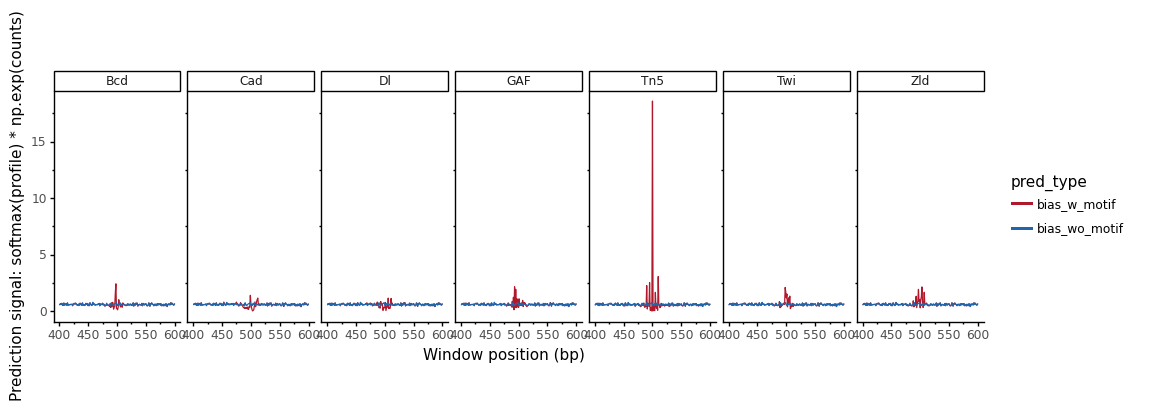

<ggplot: (8792079317245)>


In [20]:
from plotnine import *
import plotnine

plotnine.options.figure_size = (12, 3)

motif_inj_plots = (ggplot(data = preds_df, mapping = aes(x = 'position', y = 'pred_signal', color = 'pred_type'))+
    geom_line()+
    scale_x_continuous(limits = [400, 600], name = 'Window position (bp)')+
    scale_y_continuous(name = 'Prediction signal: softmax(profile) * np.exp(counts)')+          
    scale_color_manual(values = ['#b2182b', '#2166ac'])+
    facet_grid('. ~ motif')+
    theme_classic()
)
motif_inj_plots.save(f'{figure_filepath}/bias_validation_motif_injection_response.png')
motif_inj_plots.save(f'{figure_filepath}/bias_validation_motif_injection_response.pdf')
print(motif_inj_plots)

Here, we can see that there is no increase in counts, and that the "Tn5 motif" is highly responsive as compared to the other motifs injected in terms of profile.

Also, TF-MoDISco counts and profile interpretations showed only Tn5 motifs in the profile contribution, and no motifs in the counts contribution. This shows that our bias model was successfully trained to only represent Tn5 bias at closed regions.

# Optimize ChromBPNet model

Here, our aim in this manuscript is to train ChromBPNet on four different models, each for a different chromatin accessibility timepoint. In order to maintain stability and control between the models, the information the models are seeing, the how the models are structured in terms of architecture, we seek to do the following:

1. Train each timepoint on the same region set (a concatenated list of reproducible, formatted accessible sites for all 4 timepoints)
2. Train each timepoint on the same model architecture. 

In order to do this, we want to optimize some parameters because we know that the fly genome is far more condensed than the mouse/human genomes that ChromBPNet was originally designed to describe. For this, we aim to look at:

1. Number of filters: the complexity of the system depends on this value. If mammalian grammar complexity is higher, a lower value might be sufficient for training.
2. Convolutional filter length: `filter length of nondilated convolutional layer`
3. Deconvolutional filter length: `filter length of deconvolutional layer`
4. Counts to profile weights: `lambda`

These are the parameters that should be most impactful towards learning the cis-regulatory sequence grammar that dictates ATAC-seq cutsites. Other than this, we will keep the other model parameters such as counts weights (lambda), negative sampling rates, learning rates etc the same as the bias model, which was trained on ChromBPNet defaults (as enzymatic sequence bias should not be different across model systems).

We will assess each of these in an independent fashion deviating from default model selections for a single timepoint. The timepoint we will pick is the 2.5-3hr timepoint because it has the most dynamic of TF coordination/cooperativity and is likely to contain the most complex of sequence-based grammar. We also trained the bias model above on this coverage, so to maintain consistency we will optimize a few parameters to this timepoint as well and then apply the architecture to all 4 timepoints.

In [21]:
parameter_options_dict = {
    'filt': [128, 256, 512],
    'filtconv': [7, 15, 21],
    'profileconv': [7, 15, 21, 75],
    'cw': [.1, .25, .5]
}

Write `.sge` files for different model runs of these features.

In [22]:
for param_type, param_options in parameter_options_dict.items():
    for param_value in param_options:
        
        #Set defaults
        default_options_dict = {
            'cw': .1,
            'filt': 512, 
            'filtconv': 21,
            'profileconv': 75
        }
        
        #Reassign the value of interest
        default_options_dict[param_type] = param_value
        
        #Set values
        cw = default_options_dict['cw']
        filt = default_options_dict['filt']
        filtconv = default_options_dict['filtconv']
        profileconv = default_options_dict['profileconv']
        
        #Write training script
        print(f'chrombpnet_train_cw{cw}_filt{filt}_fc{filtconv}_pc{profileconv}')
        write_train_sge(f'tmp/chrombpnet_train_cw{cw}_filt{filt}_fc{filtconv}_pc{profileconv}.sge',
                       BASE_DIR = BASE_DIR, INPUT_SEQLEN = INPUT_SEQLEN, OUTPUT_SEQLEN=OUTPUT_SEQLEN,
                       CHROM_SIZES = CHROM_SIZES, REFERENCE_GENOME = REFERENCE_GENOME,
                       TEST_CHROM = test_chromosome, VALID_CHROM = valid_chromosome, 
                       CVG=OPT_TRAINING_CVG, PEAK_BED=OPT_TRAINING_PEAKS, NONPEAK_BED=OPT_TRAINING_NONPEAKS, 
                       PRETRAINED_BIAS=PRETRAINED_BIAS,
                       cw = cw, filt = filt, filtconv=filtconv, profileconv= profileconv)
        

chrombpnet_train_cw0.1_filt128_fc21_pc75
chrombpnet_train_cw0.1_filt256_fc21_pc75
chrombpnet_train_cw0.1_filt512_fc21_pc75
chrombpnet_train_cw0.1_filt512_fc7_pc75
chrombpnet_train_cw0.1_filt512_fc15_pc75
chrombpnet_train_cw0.1_filt512_fc21_pc75
chrombpnet_train_cw0.1_filt512_fc21_pc7
chrombpnet_train_cw0.1_filt512_fc21_pc15
chrombpnet_train_cw0.1_filt512_fc21_pc21
chrombpnet_train_cw0.1_filt512_fc21_pc75
chrombpnet_train_cw0.1_filt512_fc21_pc75
chrombpnet_train_cw0.25_filt512_fc21_pc75
chrombpnet_train_cw0.5_filt512_fc21_pc75


In [23]:
cmds = ['#!/bin/bash']
for i in glob('tmp/chrombpnet_train_cw*.sge'):
    cmd = 'qsub ' + i
    cmds.append(cmd)
    
with open('tmp/chrombpnet_optimize.sh', mode='wt') as opt:
    opt.write('\n'.join(cmds))
    opt.write('\n')    

In [24]:
%%script false --no-raise-error
!bash tmp/chrombpnet_optimize.sh

## Collect optimization outcome values

In [25]:
df = import_metrics(metrics_expression_path = 'chrombpnet/metrics/model_nsr*.json')
df[['model','nsr', 'lr', 'cw', 'filt', 'ndil', 'fc', 'pc']] = df.path.str.split('_', expand=True)
df['pc'] = df['pc'].str.replace('.metrics.json', '')
df.columns = ['counts_p_all', 'counts_s_all', 'binary_auc', 'counts_p_peaks', 'counts_s_peaks', 
              'counts_p_peaks_nobias', 'counts_s_peaks_nobias', 'counts_p_peaks_biasonly', 'counts_s_peaks_biasonly',
              'jsd_peaks', 'jsd_peaks_nobias', 'jsd_peak_onlybias', 'jsd_random', 'path', 
              'model','nsr', 'lr', 'cw', 'filt', 'ndil', 'fc', 'pc']
df

,counts_p_all,counts_s_all,binary_auc,counts_p_peaks,counts_s_peaks,counts_p_peaks_nobias,counts_s_peaks_nobias,counts_p_peaks_biasonly,counts_s_peaks_biasonly,jsd_peaks,...,jsd_random,path,model,nsr,lr,cw,filt,ndil,fc,pc
0,0.681952,0.610191,0.728287,0.553972,0.554342,0.549419,0.558374,0.062280,0.021141,0.327572,...,0.670593,model_nsr0.1_lr0.001_cw0.5_filt512_ndil8_fc21_...,model,nsr0.1,lr0.001,cw0.5,filt512,ndil8,fc21,pc75
0,0.689340,0.603550,0.731544,0.564899,0.551240,0.556560,0.552796,0.062280,0.021141,0.327333,...,0.669791,model_nsr0.1_lr0.001_cw0.25_filt512_ndil8_fc21...,model,nsr0.1,lr0.001,cw0.25,filt512,ndil8,fc21,pc75
0,0.686744,0.642150,0.742499,0.569653,0.578447,0.607712,0.586177,0.062280,0.021141,0.322404,...,0.671772,model_nsr0.1_lr0.001_cw0.1_filt512_ndil8_fc21_...,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc21
0,0.667085,0.655891,0.801610,0.605961,0.600637,0.515868,0.483831,0.544114,0.559254,0.267079,...,0.650370,model_nsr0.1_lr0.001_cw0.1_filt512_ndil8_fc7_p...,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc7,pc75
0,0.708790,0.619635,0.753385,0.575258,0.546323,0.581771,0.558213,0.062280,0.021141,0.320190,...,0.672155,model_nsr0.1_lr0.001_cw0.1_filt512_ndil8_fc21_...,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc7
0,0.636794,0.615658,0.767110,0.466794,0.540758,0.548738,0.557500,0.062280,0.021141,0.324136,...,0.670616,model_nsr0.1_lr0.001_cw0.1_filt256_ndil8_fc21_...,model,nsr0.1,lr0.001,cw0.1,filt256,ndil8,fc21,pc75
0,0.697412,0.630082,0.738076,0.565948,0.566385,0.562907,0.575268,0.062280,0.021141,0.322832,...,0.670860,model_nsr0.1_lr0.001_cw0.1_filt512_ndil8_fc21_...,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc15
0,0.628197,0.590523,0.772382,0.467682,0.516996,0.529531,0.521991,0.062280,0.021141,0.328197,...,0.669673,model_nsr0.1_lr0.001_cw0.1_filt128_ndil8_fc21_...,model,nsr0.1,lr0.001,cw0.1,filt128,ndil8,fc21,pc75
0,0.667541,0.642708,0.770266,0.520816,0.576369,0.590063,0.586265,0.062280,0.021141,0.320638,...,0.672117,model_nsr0.1_lr0.001_cw0.1_filt512_ndil8_fc15_...,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc15,pc75
0,0.695877,0.652613,0.761705,0.570748,0.587391,0.617975,0.596827,0.062280,0.021141,0.321760,...,0.670791,model_nsr0.1_lr0.001_cw0.1_filt512_ndil8_fc21_...,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc75


Here we can see that the `bias_only` columns are not contributing to counts correlation scores at all, showing that the bias model trained above only corrects for Tn5 positional bias.

In [26]:
eval_df = df[['model','nsr', 'lr', 'cw', 'filt', 'ndil', 'fc', 'pc',
              'counts_p_peaks_nobias', 'counts_s_peaks_nobias', 'binary_auc',
              'jsd_peaks_nobias', 'jsd_random']]
eval_df

,model,nsr,lr,cw,filt,ndil,fc,pc,counts_p_peaks_nobias,counts_s_peaks_nobias,binary_auc,jsd_peaks_nobias,jsd_random
0,model,nsr0.1,lr0.001,cw0.5,filt512,ndil8,fc21,pc75,0.549419,0.558374,0.728287,0.570139,0.670593
0,model,nsr0.1,lr0.001,cw0.25,filt512,ndil8,fc21,pc75,0.556560,0.552796,0.731544,0.570988,0.669791
0,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc21,0.607712,0.586177,0.742499,0.561169,0.671772
0,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc7,pc75,0.515868,0.483831,0.801610,0.519825,0.650370
0,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc7,0.581771,0.558213,0.753385,0.558445,0.672155
0,model,nsr0.1,lr0.001,cw0.1,filt256,ndil8,fc21,pc75,0.548738,0.557500,0.767110,0.565740,0.670616
0,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc15,0.562907,0.575268,0.738076,0.562545,0.670860
0,model,nsr0.1,lr0.001,cw0.1,filt128,ndil8,fc21,pc75,0.529531,0.521991,0.772382,0.575560,0.669673
0,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc15,pc75,0.590063,0.586265,0.770266,0.559830,0.672117
0,model,nsr0.1,lr0.001,cw0.1,filt512,ndil8,fc21,pc75,0.617975,0.596827,0.761705,0.562157,0.670791


## Summary of parameter results

We will select the optimal model based on a balance of well-performing of counts correlation, binary AUC scores, and Jensen-Shannon distance (not divergence) values that have the bias model removed (as we will not be evaluating the bias model downstream of this analysis). Good counts correlations usually penalized the binaryAUC and JSD, so we will have to select a balance based on performance, stability, and model downsizing (a smaller model is always better, there is always a concern for overdistribution of sequence grammar in a too-deep model that focuses too much on kmer noise and not enough on motif-driven sequence grammar).

+ `fc`: differences in filter convolutional size were negligible (with good binaryAUC and JSD scores resulting in slightly penalized counts correlations). For this, we selected 7bp in width because it provided the best spearman correlation scores with accompanying good JSD and binaryAUC scores. Additionally, this "PWM scanning" step being 7bp matches our expectations still of the kind of motifs represented using this filter length.

+ `pc`: differences in filter convolutional size were negligible (with good counts correlations resulting in slightly penalized binaryAUC and JSD scores). For this, we selected 75bp in width because it provided the best spearman correlation scores with accompanying good JSD and binaryAUC scores. Additionally, this "PWM scanning" step being 75bp matches our expectations still of the kind of motifs represented using this filter length.

+ `filt`: as filter depth increased, we saw an improvement in counts correlation (albeit very small) and a degeneration of peak-vs-nonpeak accuracy (binaryAUC). These differences were negligible however. Because filter depth is the parameter that determines the "complexity space" by which sequence grammar is learned, it is important to remember that creating a too-deep model can result in overdistribution of motif representations, which will result in increased noise prediction and decreased motif grammar attention. Because of this, counts correlation scores can often improve because of the global representation, but still produce higher noise in attribution scores (contribution scores) that draws learning away from motif-driven grammar. Previous analysis in the lab has shown that early embryo fly models work better with smaller filter depths (128 was always the optimal setting for getting high quality contribution scores at motifs of interest. In order to follow that consensus, we selected 128 filters to avoid overfitting and overdistribution of motif grammar (thus introducing greater attention to noise). 

+ `cw`: a counts:profile ratio of 10% was preferable and resulted in overall higher scoring. This ratio is well established to be a good balance between peak mangnitude predictions and signal accuracy (especially because fly early embryo ATAC-seq is noisier than mammalian cell lines).

In [27]:
eval_df.to_csv('tsv/optimization/chrombpnet_optimization_of_parameters.tsv.gz', sep = '\t', index = False)

# 3-fold validation

We will run two other models with the same optimized architectures with the training/validation/test chromosomes shuffled around. The purpose of this analysis is to establish that the regions selected for training in our above model are representative of the entire dataset. After training, in subsequent documents we will record running TF-MoDISco to show the motifs learned are similar. 




First, we will train the models, however.

In [28]:
fold_chr_dict = {
    1: {'valid': 'chr2L', 'test': 'chrX'},
    2: {'valid': 'chr3L', 'test': 'chr2R'},
    3: {'valid': 'chrX', 'test': 'chr3R'}
}

for fold in range(1,4):
    for t in TIMEPOINTS:
        write_train_sge(f'tmp/chrombpnet_train_fold{fold}_{t}.sge',
                        BASE_DIR = BASE_DIR, INPUT_SEQLEN = INPUT_SEQLEN, OUTPUT_SEQLEN=OUTPUT_SEQLEN,
                        CHROM_SIZES = CHROM_SIZES, REFERENCE_GENOME = REFERENCE_GENOME,
                        TEST_CHROM = fold_chr_dict[fold]['test'], VALID_CHROM = fold_chr_dict[fold]['valid'], 
                        CVG=combined_cvg_path_dict[t], PEAK_BED=combined_peak_path, NONPEAK_BED=combined_nonpeak_path, 
                        PRETRAINED_BIAS=PRETRAINED_BIAS, 
                        filt = 128, filtconv=7, profileconv= 75, #optimized parameters that deviate from defaults
                        generate_contrib = True, rename_to_prefix = f'fold{fold}_{t}')

In [29]:
cmds = ['#!/bin/bash']
for i in glob('tmp/chrombpnet_train_fold*.sge'):
    cmd = 'qsub ' + i
    cmds.append(cmd)
    
with open('tmp/chrombpnet_train.sh', mode='wt') as opt:
    opt.write('\n'.join(cmds))
    opt.write('\n')    

In [30]:
%%script false --no-raise-error
!bash tmp/chrombpnet_train_fold_timepoint.sh

Next, we will assess whether the fold-change model evaluation returns similar performance metrics.

In [31]:
df = import_metrics(metrics_expression_path = 'chrombpnet/metrics/model_fold*.json')
df[['model','fold', 'timepoint']] = df.path.str.split('_', expand=True)
df['timepoint'] = df['timepoint'].str.replace('.metrics.json', '')
df.columns = ['counts_p_all', 'counts_s_all', 'binary_auc', 'counts_p_peaks', 'counts_s_peaks', 
              'counts_p_peaks_nobias', 'counts_s_peaks_nobias', 'counts_p_peaks_biasonly', 'counts_s_peaks_biasonly',
              'jsd_peaks', 'jsd_peaks_nobias', 'jsd_peak_onlybias', 'jsd_random', 'path', 
              'model','fold', 'timepoint']
df.sort_values(['fold', 'timepoint'])

,counts_p_all,counts_s_all,binary_auc,counts_p_peaks,counts_s_peaks,counts_p_peaks_nobias,counts_s_peaks_nobias,counts_p_peaks_biasonly,counts_s_peaks_biasonly,jsd_peaks,jsd_peaks_nobias,jsd_peak_onlybias,jsd_random,path,model,fold,timepoint
0,0.773630,0.728147,0.642632,0.643620,0.668661,0.658420,0.685304,0.439691,0.488145,0.299214,0.562814,0.310485,0.654433,model_fold1_15to2.metrics.json,model,fold1,15to2
0,0.678012,0.559242,0.705272,0.489188,0.466172,0.519986,0.462081,0.237196,0.224022,0.357315,0.599842,0.364936,0.669199,model_fold1_1to15.metrics.json,model,fold1,1to15
0,0.690389,0.641615,0.769338,0.560771,0.582361,0.606402,0.589140,0.062280,0.021141,0.325463,0.567838,0.340108,0.670754,model_fold1_25to3.metrics.json,model,fold1,25to3
0,0.715637,0.656701,0.717034,0.556814,0.579243,0.608333,0.598127,0.225636,0.208209,0.315578,0.561096,0.328619,0.664954,model_fold1_2to25.metrics.json,model,fold1,2to25
0,0.741035,0.767679,0.655817,0.699997,0.734516,0.701802,0.725040,0.556643,0.593209,0.264864,0.545788,0.274413,0.641545,model_fold2_15to2.metrics.json,model,fold2,15to2
0,0.528468,0.536544,0.682832,0.428664,0.446444,0.431455,0.437724,0.260667,0.300691,0.324337,0.583154,0.330889,0.655208,model_fold2_1to15.metrics.json,model,fold2,1to15
0,0.592444,0.588817,0.746815,0.554713,0.536984,0.553200,0.534727,0.048055,0.041176,0.288590,0.553296,0.303062,0.657644,model_fold2_25to3.metrics.json,model,fold2,25to3
0,0.668910,0.692446,0.738386,0.628653,0.642412,0.631880,0.629069,0.296161,0.314975,0.280499,0.545606,0.292803,0.653531,model_fold2_2to25.metrics.json,model,fold2,2to25
0,0.668934,0.746377,0.630872,0.595034,0.708396,0.699908,0.741137,0.544114,0.559254,0.263671,0.545029,0.275192,0.642651,model_fold3_15to2.metrics.json,model,fold3,15to2
0,0.525437,0.534727,0.665223,0.405298,0.441578,0.474632,0.496061,0.215731,0.263395,0.327200,0.584013,0.334105,0.655460,model_fold3_1to15.metrics.json,model,fold3,1to15


In [32]:
fold_df = df[['fold', 'timepoint',
              'counts_p_all', 'counts_s_all', 'binary_auc',
              'jsd_peaks', 'jsd_random']]
fold_df.sort_values(['timepoint', 'fold'])

,fold,timepoint,counts_p_all,counts_s_all,binary_auc,jsd_peaks,jsd_random
0,fold1,15to2,0.773630,0.728147,0.642632,0.299214,0.654433
0,fold2,15to2,0.741035,0.767679,0.655817,0.264864,0.641545
0,fold3,15to2,0.668934,0.746377,0.630872,0.263671,0.642651
0,fold1,1to15,0.678012,0.559242,0.705272,0.357315,0.669199
0,fold2,1to15,0.528468,0.536544,0.682832,0.324337,0.655208
0,fold3,1to15,0.525437,0.534727,0.665223,0.327200,0.655460
0,fold1,25to3,0.690389,0.641615,0.769338,0.325463,0.670754
0,fold2,25to3,0.592444,0.588817,0.746815,0.288590,0.657644
0,fold3,25to3,0.514413,0.589009,0.750208,0.288796,0.658556
0,fold1,2to25,0.715637,0.656701,0.717034,0.315578,0.664954


Model performance metrics do not look largely different, except for `fold2` in timepoints `15to2`. Best way of determining whether the model systematically learned the correct features now is to run TF-MoDISco to ensure that all the motif grammar that we expect from TF binding behavior is returned as well.

Now that these models have been trained, we will run TF-MoDISco in later documents and also generate data to compare to these models.

In [33]:
fold_df.to_csv('tsv/optimization/chrombpnet_fold_validation_of_parameters.tsv.gz', sep = '\t', index = False)

# Generate predictions and contributions scores as .bw files

In order to assess performance and run TF-MoDISco, we can extract predictions from ChromBPNet for both output preds and shap scores.

In [34]:
for fold in range(1,4):
    for t in TIMEPOINTS:
        write_predict_sge(f'tmp/chrombpnet_predict_fold{fold}_{t}.sge', BASE_DIR = BASE_DIR, 
                          CHROM_SIZES = BASE_DIR + '/' + CHROM_SIZES, 
                          REFERENCE_GENOME = BASE_DIR + '/' + REFERENCE_GENOME,
                          PEAK_BED = BASE_DIR + '/' + combined_peak_path,
                          PREFIX = f'fold{fold}_{t}')

In [35]:
cmds = ['#!/bin/bash']
for i in glob('tmp/chrombpnet_predict_fold*.sge'):
    cmd = 'qsub ' + i
    cmds.append(cmd)
    
with open('tmp/chrombpnet_predict.sh', mode='wt') as opt:
    opt.write('\n'.join(cmds))
    opt.write('\n')    

In [36]:
%%script false --no-raise-error
!bash tmp/chrombpnet_predict.sh

# Run TF-MoDISco 

Now that the different models have been optimized, trained in different folds, and the contributions have been generated, we can run TF-MoDISco to group the important sequence features.

In [37]:
for fold in range(1,4):
    for t in TIMEPOINTS:
        write_modisco_sh(OUTPUT_SH_PATH = f'tmp/chrombpnet_modisco_fold{fold}_{t}.sh',
                         BASE_DIR = BASE_DIR,
                         PREFIX = f'fold{fold}_{t}')

In [38]:
cmds = ['#!/bin/bash']
for i in glob('tmp/chrombpnet_modisco_fold*.sh'):
    cmd = 'bash ' + i
    cmds.append(cmd)
    
with open('tmp/chrombpnet_modisco.sh', mode='wt') as opt:
    opt.write('\n'.join(cmds))
    opt.write('\n')    

In [39]:
%%script false --no-raise-error
!bash tmp/chrombpnet_modisco.sh

For overviews of each TF-MoDISco run, go to `analysis/chrombpnet/modisco/*/*`. This will show all the logos returned. Metaplots were not generated and motifs were not mapped, as we will use the binding motifs from `2*.ipynb` to guide our motif locations. ChromBPNet models will be used as predictors only.

## Collect TF-MoDISco seqlets into .bed files.

Collect seqlet.txt files derived from motif_discovery, map genomic coordinates to the regions, then export into a .bed file. Remember, these TF-MoDISco regions have not been trimmed by information content so will always cover a 50bp region (or whatever the TF-MoDISco settings specify).

In [40]:
for fold in tqdm(range(1,4)):
    for t in TIMEPOINTS:
        input_peak_path = f'chrombpnet/shap/shap_fold{fold}_{t}.interpreted_regions.bed'
        input_seqlets = glob(f'chrombpnet/modisco/fold{fold}_{t}_counts/*pattern_*_seqlets.txt')
        for i in input_seqlets:
            seqlets_df = import_modisco_seqlets_txt(i)
            mapped_seqlets_df = map_modisco_coordinates_to_genome(seqlets_df = seqlets_df, 
                                                                  input_peak_path = input_peak_path, 
                                                                  fasta_path = REFERENCE_GENOME, 
                                                                  input_seqlen = INPUT_SEQLEN, output_seqlen = OUTPUT_SEQLEN,
                                                                  #defaults are based on basepairmodels 'start' column as column 11, change.
                                                                  peak_col_names = ['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'p', 'q', 'summit']) 
            
            mapped_seqlets_df['score'] = 0
            seqlets_bed = mapped_seqlets_df[['chrom', 'genomic_motif_start', 'genomic_motif_end', 'region_id', 'score', 'genomic_motif_strand']]
            seqlets_bed.to_csv(i.replace('.txt', '.bed'), sep = '\t', header = False, index = False)

100%|██████████| 3/3 [02:09<00:00, 43.18s/it]


# Comparison of best model with observed/replicate quality metrics 

Here, we will generate plots for each of the optimized model folds across each timepoint to give a sense of performance. Counts correlation scores with bias removed will be sufficient to determine `obs vs pred` comparisons. However, profile prediction assessment tools such as `auPRC` from Avsec et al 2021 do not make sense in ChromBPNet because comparing observed and predicted cutsite tracks is largely an asssessment of how well Tn5 positional bias is being predicted.

First, we will measure the counts correlation scores.

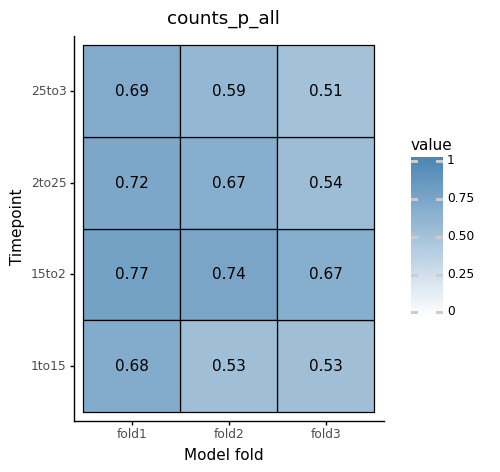

<ggplot: (8791546897444)>


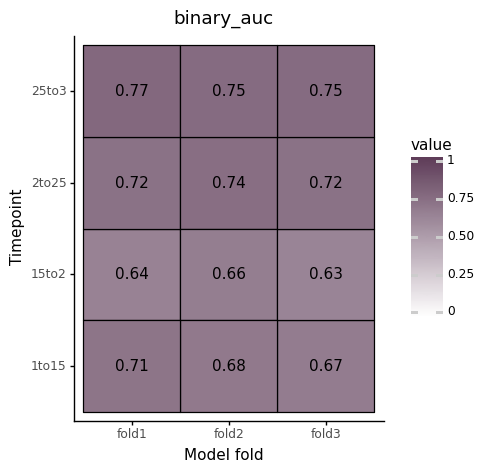

<ggplot: (-9223363243935303287)>


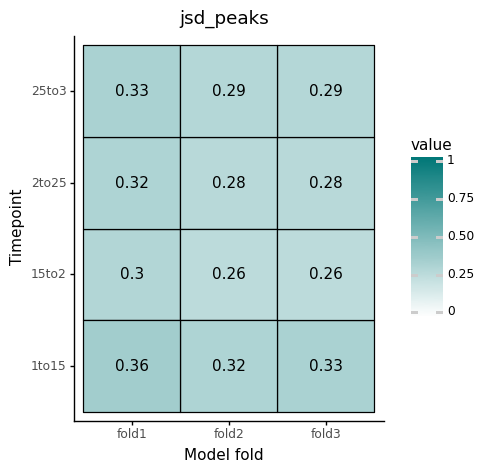

<ggplot: (8791546897486)>


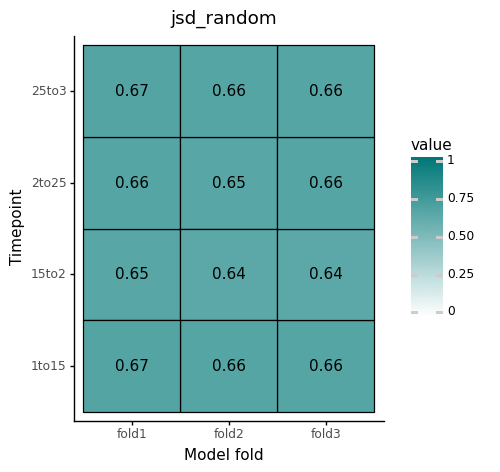

<ggplot: (-9223363245314687046)>


In [41]:
fold_df['counts_p_all'] = np.round(fold_df['counts_p_all'].values, 2)
fold_df['binary_auc'] = np.round(fold_df['binary_auc'].values, 2)
fold_df['jsd_peaks'] = np.round(fold_df['jsd_peaks'].values, 2)
fold_df['jsd_random'] = np.round(fold_df['jsd_random'].values, 2)
fold_df['timepoint'] = pd.Categorical(fold_df['timepoint'], ordered=False, categories = TIMEPOINTS)

cols_to_keep = ['timepoint', 'fold', 'counts_p_all', 'counts_s_all', 'binary_auc','jsd_peaks', 'jsd_random']
metrics_melt_df = fold_df[cols_to_keep].melt(id_vars = ['timepoint', 'fold'], var_name = 'metric', value_name = 'value')

plotnine.options.figure_size = (4, 5)
colors = ['#4b86b4', '#5e3c58', '#007777', '#007777']

for i,m in enumerate(['counts_p_all','binary_auc', 'jsd_peaks', 'jsd_random']):
    
    m_df = metrics_melt_df[metrics_melt_df.metric==m]
    metrics_plot = (ggplot(data = m_df, mapping = aes(x = 'fold', y = 'timepoint', fill = 'value'))+
        geom_tile(color = 'black', size = .5)+
        geom_text(aes(label = 'value'))+
        scale_fill_gradient2(limits = (0,1), low = 'white', high = colors[i])+
        scale_x_discrete(name = 'Model fold')+
        scale_y_discrete(name = 'Timepoint')+
        ggtitle(m)+
#         facet_wrap(' ~ metric', nrow = 2)+
        theme_classic())
    print(metrics_plot)

    metrics_plot.save(f'{figure_filepath}/chrombpnet_foldvalidation_{m}.png', dpi=300)
    metrics_plot.save(f'{figure_filepath}/chrombpnet_foldvalidation_{m}.pdf')

Here, we can see that the metrics are relatively stable, especially profile performance (JSD). Counts performance has a wider range of performance, but remains between ~0.5-0.7. Though we optimized the architecture based on the performance of the latest timepoint (25to3), the other timepoints also perform well with this architecture. 